# Deep Learning - Final Project - Deep Music 
### *Or Segal*

***

For this project, I will aim to drill deeper (pun intended) on using deep learning with music data and particularly for generating music. The main focus will be assessing which types of deep network architectures are the most appropriate for music data, with a primary comparison between autoencoders and recurrent neural networks (RNN; specifically Long short-term memory (LSTM) networks). 

For both of the network architectures, I used data that was not previously used in assignment 3. Out of __[the large dataset](https://colinraffel.com/projects/lmd/)__ that contains 2199 artists and 17243 songs, I chose the artist with the largest number of songs which was (luckily) the best band in history - The Beatles. Out of the available 783 Beatles songs, I used only the piano pieces and ended up with a bit over twice as many notes as there were in the original __[Final Fantasy soundtrack dataset](https://github.com/Skuldur/Classical-Piano-Composer)__ that was used in the previous assignment.

The first section of this report will discuss the type of data used in the work (MIDI files) as well as the extraction and pre-processing of the data. I will then describe the AE architecture and the adaptations done to improve the performance compared to the work previously presented in assignment 3. For the third section, I will generally explain what are LSTM networks and present the implementation and results using the new data. Finally, I will conclude with a comparison between the two.



In [8]:
# imports 

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, LSTM, Activation, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, TensorBoard
from numpy.testing import assert_allclose

import glob
import time
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
import operator

plt.style.use('ggplot')

## Data Format, Extraction, and Pre-Processing

First, I will download and extract __[the large dataset](https://colinraffel.com/projects/lmd/)__ which contains 17243 songs. Out of that dataset I will aim to focus the data so that it all comes from one musician. For that, I will look up which musician has the largest number of songs:

In [ ]:
# Download the dataset and extract it

import shutil
import requests
import tarfile

url = 'http://hog.ee.columbia.edu/craffel/lmd/clean_midi.tar.gz'
response = requests.get(url, stream=True)
with open('clean_midi.tar.gz', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response    


tar = tarfile.open("clean_midi.tar.gz")
tar.extractall()
tar.close()

In [8]:
folder_path = "clean_midi/*/*.mid"
print("Number of MIDI files in the folder: {}".format(len(glob.glob(folder_path)))

snippets_largeDataSet = get_notes_AE(folder_path=folder_path)

Number of MIDI files in the folder: 17243


In [7]:
import os                                                                                                             

subdir_sizes = []
subdirs = [x[0] for x in os.walk("clean_midi/")]                                                                            
for subdir in subdirs:                                                                                            
    files = [files for r, d, files in os.walk(subdir)][0]
    subdir_sizes.append(len(files))
    
print("The musician with the largest number opf songs: {}".format(subdirs[subdir_sizes.index(max(subdir_sizes))]))

The musician with the largest number opf songs: clean_midi/The Beatles


We found that the musician with the largest number of files are The Beatles. Fun stuff!

All the data that we have is stored as MIDI files. MIDI files store notes with the added information of octave, pitch, and offset (distance from the last note), as well as  chords which are sets of notes played together. In each file, there could be several instruments stored together. To simplify the data, I will follow __[the original LSTM tutorial](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5 )__ and treat all offset as the same (as it is mostly an offset of 0.5 for all notes and chords anyway) which will leave us with a list of notes and chords played one after the other. As we will see, there are 365 different notes and chords in the data. The original tutorial worked with the Final Fantasy soundtrack which was all in piano, however here we have different instruments in each file. I will assume now that it will be hard for a network to work with more than one instrument, so for now we will keep it simple and work only with one. In that case, let's take the instrument that has the largest number of notes from the Beatles files:


In [24]:
# Get all the beatles files from the folder, and sample n_flies from them
beatles_files = [files for r, d, files in os.walk("beatles_midi/")][0]        
        
inst_list = []
start_time = time.time()
counter = 1
for file in np.random.choice(beatles_files, 200, replace=False):
    print("\rParsing {counter}/{n_files} - {file}. Time: {time:.2f} seconds"
          .format(file=file, counter=counter, n_files=len(beatles_files), 
                  time=time.time()-start_time), end="")
    midi = converter.parse("beatles_midi/" + file)
    partStream = midi.parts.stream()
    for p in partStream:
        inst_list.append(p.partName)
    counter += 1

Parsing 200/783 - Come Together.3.mid. Time: 60.35 seconds

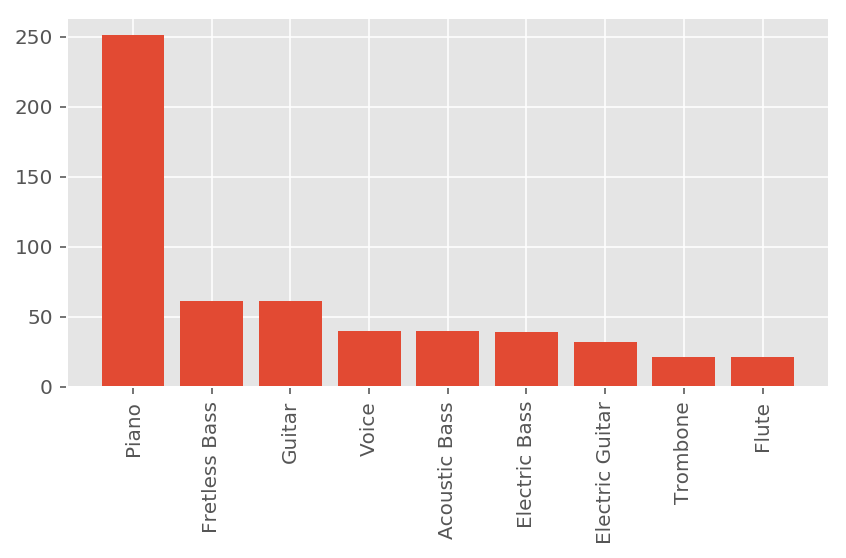

In [23]:
sorted_counter = sorted(Counter(inst_list).items(), key=operator.itemgetter(1))
sorted_counter.reverse()
inst_counter = sorted_counter[1:10] # first one is "none", so we don't count it

x, y = zip(*inst_counter)

plt.bar(x, y)
plt.xticks(x, x, rotation='vertical')
plt.tight_layout()
plt.show()

Piano it is then!

I will show here the final part of the pre-processing which is applicable for the training of the AE. The pre-processing for the LSTM network will be presented below. To make things even more simple for training, I will cut all of the MIDI files to snippets of the same length (100 notes and chords) which will make sure that the network will always get the same input. 

The `get_notes_for_AE` function was changed from the previous assignment to adapt it to work with the Beatles files and only take the piano notes and chords. The function goes over all the midi files, parses the piano notes and chords (or any other instrument given as input), and stores them in batches of length 100. The `prepare_sequences_AE` function then converts all the names of the notes and chords to integers based on a mapping dictionary and normalized them (min-max normalization), similarly to the pre-processing in the LSTM tutorial.

In [ ]:
def get_notes_for_AE(n_flies=10, sequence_length=100, instrument_name="Piano"):
    """ Get all the notes and chords from the midi files in the ./beatles_midi directory """
    snippets = []
    
    # Get all the beatles files from the folder, and sample n_flies from them
    beatles_files = [files for r, d, files in os.walk("beatles_midi/")][0]
    
    start_time = time.time()
    counter = 1
    for file in np.random.choice(beatles_files, n_flies, replace=False):
        print("\rParsing {counter}/{n_files} - {file}. Time: {time:.2f} seconds"
          .format(file=file, counter=counter, n_files=n_flies, 
                  time=time.time()-start_time), end="")
        notes = []
        counter += 1 
        midi = converter.parse("beatles_midi/"+file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            for part in s2.parts:
                if part.partName == instrument_name:
                    notes_to_parse = part.recurse() 
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for i in range(len(notes) - sequence_length):
            snippets.append(notes[i:i + sequence_length])   
        
        
    with open('data/notes_beatles', 'wb') as filepath:
        pickle.dump(np.array(snippets), filepath)
    
    print("")
    
    return np.array(snippets)

def prepare_sequences_AE(notes, pitchnames):
    """ Prepare the sequences used by the Neural Network """

    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = np.vectorize(note_to_int.get)(snippets)
        
    # normalize input
    network_input = network_input / float(len(pitchnames))

    return network_input

## Autoencoder

Based on the work for the previous assignment, I will present an extended version of the relatively simple autoencoder (AE) used. The extension will mostly be the attempt to fix the bug in the code which made it not show progress in its learning as well as applying it to the Beatles data. 

In the original implementation of the AE, I aimed to follow a simple architecture, so I followed __[a tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)__ that trained a simple AE on MNIST. The AE they built flattened the MNIST database and did not use convolutions, so I worked under the assumption that my MIDI data will look close enough so that the same simple architecture will generate satisfying results. This assumption will be elaborated on in the conclusion section. The architecture they used is based on a single fully connected hidden layer (the coding layer at about 25% the size of the input) to which the input data is being encoded and then decoded.

Several attempts were made for improving the performance of the AE in learning the underlying features of the musical pieces. First, in the pre-processing of the data, I broke down the music pieces to more pieces of at length 100 (so that there would be overlap between them). Even though I did not add any new data, it mostly increased the number of pieces that the network was going over by several orders of magnitude. Second, I tested several additional network architecture and finally chose one that has a code that is larger than the one used before (50% of the input size) as well as an additional layer that reduces the size of the data prior to being encoded. Third, I ran the network for a much longer period (500 epochs) with the thought that this could be a dimension that I can leverage for a longer run when each epoch runs quickly on its own.

In [24]:
snippets = get_notes_for_AE(n_flies=200, instrument_name="Piano")

# notes_beatles_file = "data/notes_beatles"
# with open(notes_beatles_file, 'rb') as filepath:
#     snippets = pickle.load(filepath)
pitchnames = np.sort(np.unique(snippets))
network_input = prepare_sequences_AE(snippets, pitchnames)
print("Number of unique pitchnames: {}".format(len(pitchnames)))
print("Number of notes: {}".format(len(network_input)))

Parsing 200/200 - I Don't Want To Spoil The Party.mid. Time: 128.32 seconds
Number of unique pitchnames: 365
Number of notes: 102008


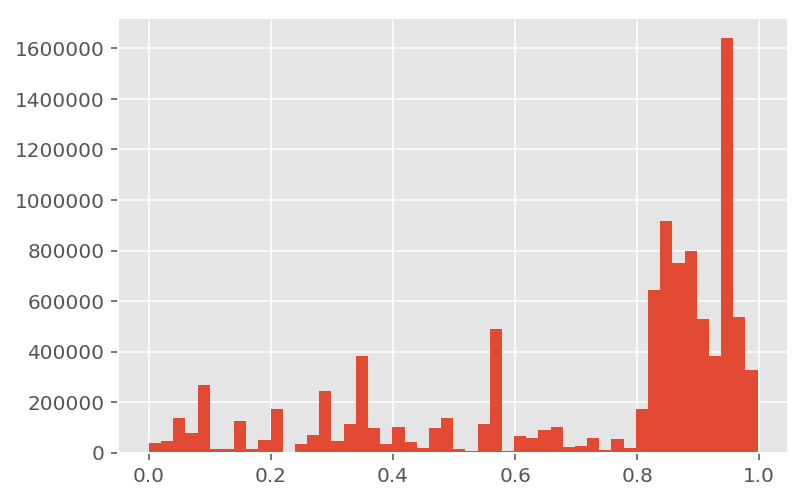

In [25]:
# Let's see the distribution of the notes

plt.hist(network_input.flatten(), bins=50)
plt.show()

In [28]:
# Taking 10% as validation set

print(snippets.shape)
print(network_input.shape)

validation_cutoff = round(len(network_input) * .9)
np.random.shuffle(network_input)
x_train, x_test = network_input[:validation_cutoff], network_input[validation_cutoff:]
print(x_train.shape, x_test.shape)

(102008, 100)
(102008, 100)
(91807, 100) (10201, 100)


### Trainings the Autoencoder



In [25]:
keras.backend.clear_session()

# this is the size of our encoded representations
original_dim = 100
hidden_dim = 75  
encoding_dim = 50 # size of code


# this is our input placeholder
input_img = Input(shape=(original_dim,))


# "encoded" is the encoded representation of the input
hidden_encode = Dense(hidden_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(hidden_encode)

# "decoded" is the lossy reconstruction of the input
hidden_decode = Dense(hidden_dim, activation='relu')(encoded)
decoded = Dense(100, activation='sigmoid')(hidden_decode)

# this model maps an input to its reconstruction
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 75)                3825      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               7600      
Total params: 22,800
Trainable params: 22,800
Non-trainable params: 0
_________________________________________________________________


In [54]:
%%time
history = autoencoder.fit(x_train, x_train,
                    epochs=500,
                    batch_size=256,
                    shuffle=True,
                    verbose=0,
                    validation_data=(x_test, x_test))

CPU times: user 48min 9s, sys: 18min 58s, total: 1h 7min 7s
Wall time: 20min 48s


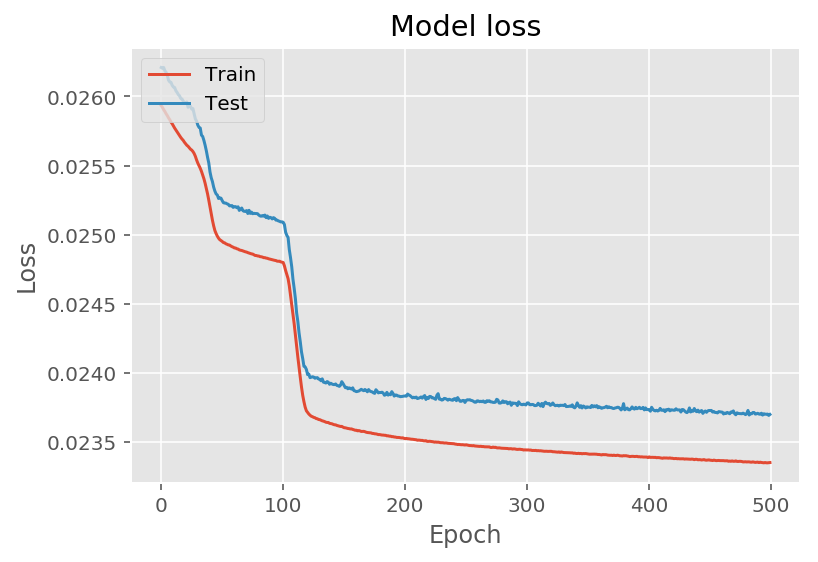

In [55]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We can see that the changes in the architecture of the network improved the learning process. An interesting observation is that the learning process here does not follow the common exponential behavior of the loss, but goes through jumps in the loss at certain points.


### Testing the Performance
To test the performance of the AE, we will take the validation set and compare an original Beatles piece of piano with its decoded version (ideally we would take a test set that the network has not seen before but because of the size of the dataset here, I decided not to do that in this case).

The `sequence_to_midi` function is the opposite to the `prepare_sequences_AE` function as it takes a set of normalized floats and converts them back to the names of the names of the notes and chords. The `create_midi` function generates a midi file from a numpy array and it was borrowed from the LSTM tutorial.

In [44]:
def sequence_to_midi(sequence, pitchnames, sequence_length=100):
    """ Prepare the sequences used by the Neural Network """

     # create a dictionary to map pitches to integers
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    
    # un-normalize input
    sequence = sequence * float(len(pitchnames))
    
    # set to the closest integer (need to think about this assumption)
    sequence = np.rint(sequence)
    
    result = np.vectorize(int_to_note.get)(sequence)
    
    return result



def create_midi(prediction_output, filename="test_output"):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename+'.mid')

In [42]:
## Good examples: 30, 40

seq_number = 40

# encoded_seq = encoder.predict(x_test)
# decoded_seq = decoder.predict(encoded_seq)
decoded_seq = autoencoder.predict(x_test)

AE_test = sequence_to_midi(decoded_seq[seq_number], pitchnames=pitchnames)
create_midi(AE_test, filename="AE_test")
AE_test_original = sequence_to_midi(x_test[seq_number], pitchnames=pitchnames)
create_midi(AE_test_original, filename="AE_test_original")
# print(AE_test_original)
# print(pitchnames)
print(len(decoded_seq), len(x_test))

10201 10201


Original version of the song:


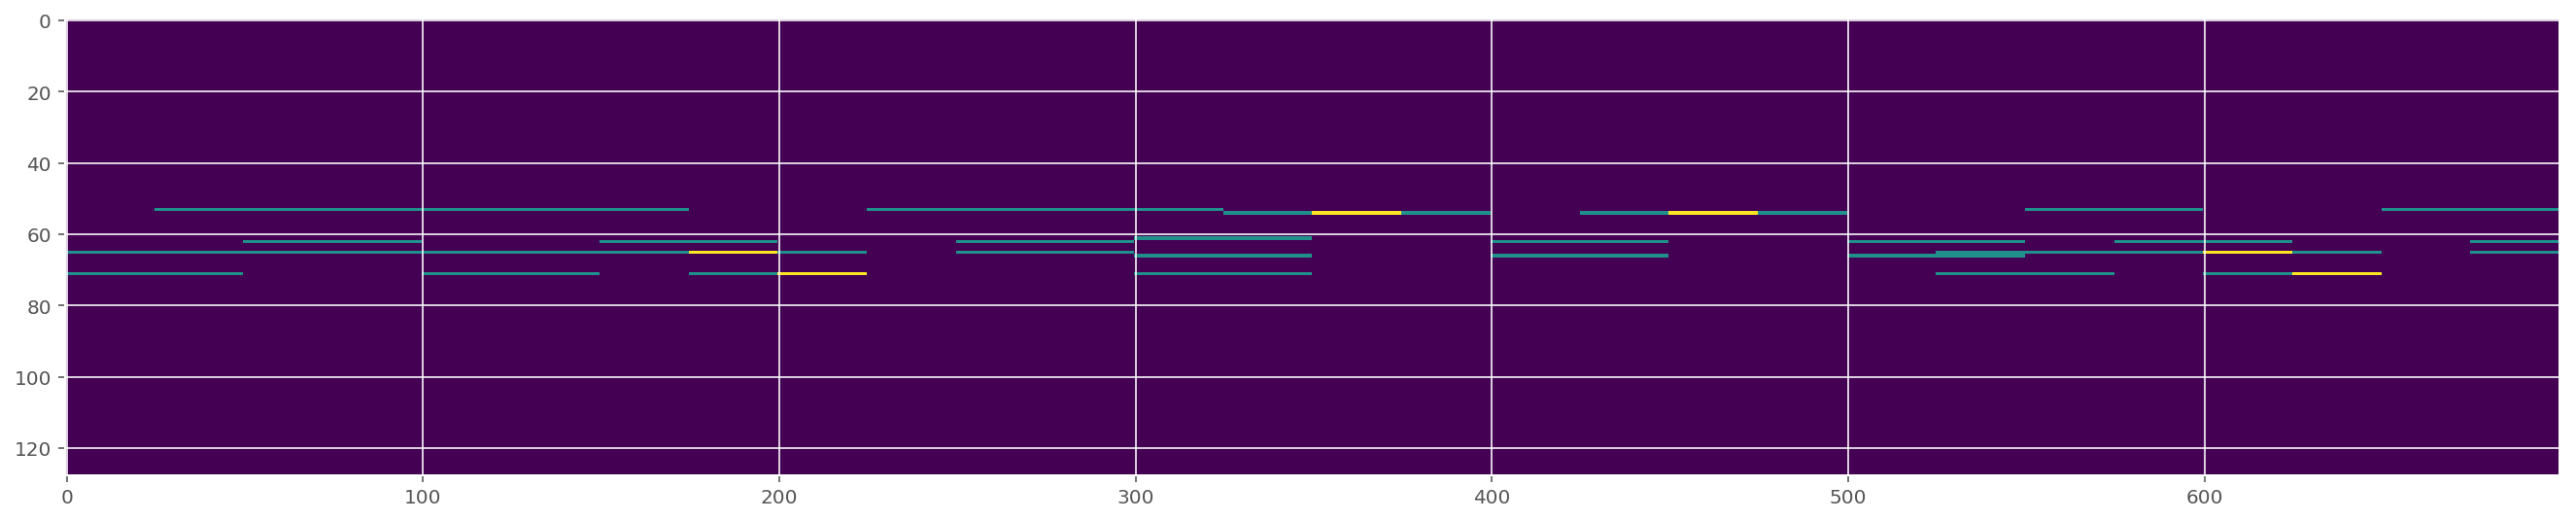

In [28]:
print("Original version of the song:")

pm = pretty_midi.PrettyMIDI("AE_test_original.mid")
plt.figure(figsize=(23,5))
plt.imshow(pm.get_piano_roll()[:,:700])
plt.show()

Decoded version of the song:


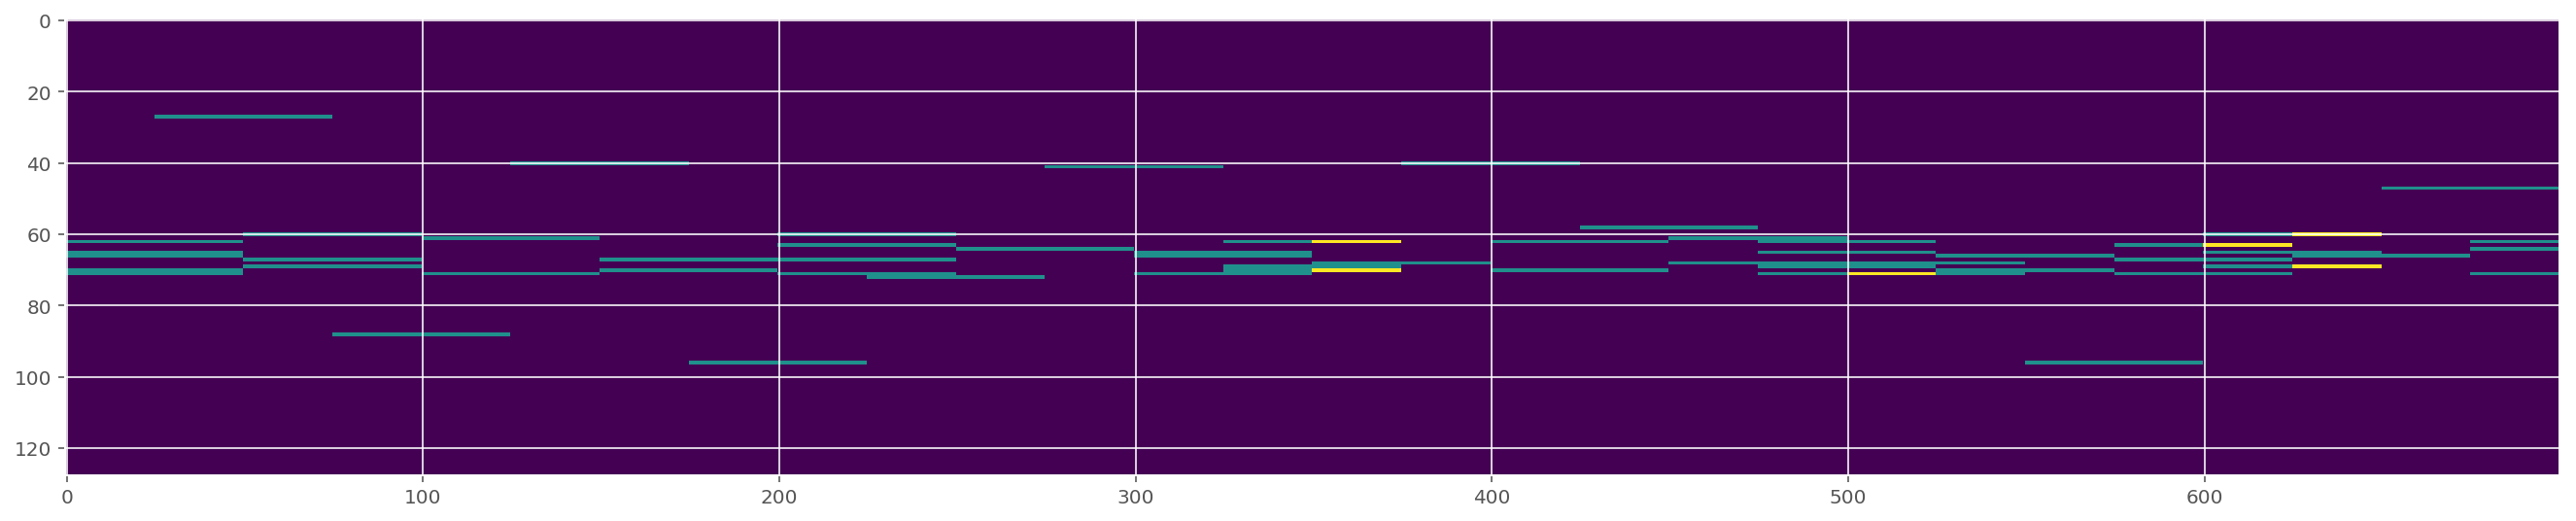

In [29]:
print("Decoded version of the song:")

pm = pretty_midi.PrettyMIDI("AE_test.mid")
plt.figure(figsize=(23,5))
plt.imshow(pm.get_piano_roll()[:,:700])
plt.show()

As we can see in the graphical plot of the notes and chords for the original and decoded version of one of the pieces. While the decoded version is far from being close to the original one, we can see that the general position of the notes and chords is relatively close (around the range of 50-70 on the y axis).

The more interesting observation happens when listening to the two versions. The two audio files can be accessed in the following links: __[the original version](https://drive.google.com/open?id=1wZlF_C9BFJb9TuQnH5ElnPffb_KoKn_C)__ and __[the decoded version](https://drive.google.com/open?id=1LoKZuz8FGlw3V1Fo-ZcGZKYoV0F4nhRL)__. Similar to the graphical representation, the audio versions still sound very different from one another. However, there are some patterns that emerge in the comparison such as having two repetitions right at the beginning of the audio track. It is possible that these patterns are just a coincidence caught by biased ears, but it might also be possible that at least some of the information was captured by the AE and the decoded piece maintains some of the original features.

In either case, there is no doubt that AE trained here did not manage to capture the detailed patterns in the Beatles music. There are two main issues that could explain this non-optimal performance. The first one relates to the pre-processing, where I convert notes to normalized floats which might not be appropriate for the data. We could form a mathematical connection between the notes, but the way we compare that same connection to the chords is problematic (is the transition between the notes B3 to B4 bigger or smaller than the transition between the chords Cm6 to Cm7?). This type of encoding was also used in the LSTM tutorial, however there the output was set to be categorical even though the input was used as a normalized numerical feature. This might not allow for a proper learning in the AE. On top of that, there could be a more general problem with using AEs in music data. It could be the case that the patterns there are just not caught well enough by the type and architecture of the autoencoder I used. 

As an alternative for autoencoders using the same data, I will now try to use a different type of network architecture that is more commonly used with music data - recurrent neural networks.

## Let's Now Try to Work with an LSTM

### Brief Intro to RNN and LSTM
Before we dive into working with our LSTM network, let's first briefly describe what is that kind of network and why is it a good option when working with music data. 

LSTMs are a type of RNNs, which are neural networks that attempt to model data with temporal or other sequential behaviors, such as language and stock price. The output of the layers from time $t$ is fed back into the same layers at time $t+1$, so that the sequential nature of the data is preserved. That way, the hidden layers are considered to be the memory of the network. Each hidden state is calculated based on the previous hidden state and the input at the current step: $s_t = f(Ux_t + Ws_{t+1})$.

![alt text](rnn.jpg)

Figure obtained from __[Skymind's AI Wiki](https://skymind.ai/wiki/lstm)__.

One major problem with RNNs is that when we try to model dependencies that are further apart in the sequence, we end up with the weights being multiplied a large number of times which often leads to the vanishing (or exploding) gradient problem. LSTM networks offer a solution to that problem by replacing the standard neural network layers with LSTM cell blocks which contain additional components such as input gates, forget gates, and output gates. The most unique part in the LSTM cell is the forget gates which form an effective layer of recurrence that uses an *addition* operation rather than a *multiplication* one. This function reduces the risk of vanishing gradients and in practice allows the network to control what is being remembered versus what is being forgotten.


![alt text](LSTM.png)

Figure obtained from __[the Adventures in Machine Learning blog post](https://adventuresinmachinelearning.com/keras-lstm-tutorial/)__.

### The LSTM Network we Used

For this section, we will be using an adaptation of the code from __[the LSTM tutorial](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5 )__ so that it will work on the Beatles data. For the pre-processing, we will be using a very similar function (`get_notes_for_LSTM`) to the one we used in the AE, however here we will just stack all the notes together in a list. We will then use the `prepare_sequences_for_LSTM` function to perform a similar translation to the one we did before from the notes and chords to a numerical value. We will then break the list to smaller lists of length 100 as an input to the network, and for each one we will use the subsequent note/chord as an expected output for the network to learn from. The inputs will be reshaped and normalized and the outputs will be turned into categorical variables. Finally, we will build the network architecture with three LSTM layers and dropout layers in between them to avoid overfitting. The last layer of the network will be a softmax so that it can predict the subsequent note or chord for the sequences it is presented with. The loss used here is a categorical cross-entropy as it is appropriate for categorical data such as the notes/chords that we have.

In [34]:
%%time

def get_notes_for_LSTM(n_flies=10, instrument_name="Piano"):
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []
    
    # Get all the beatles files from the folder, and sample n_flies from them
    beatles_files = [files for r, d, files in os.walk("beatles_midi/")][0]
    
    start_time = time.time()
    counter = 1
    for file in np.random.choice(beatles_files, n_flies, replace=False):
        midi = converter.parse("beatles_midi/"+file)

        print("\rParsing {counter}/{n_files} - {file}. Time: {time:.2f} seconds"
          .format(file=file, counter=counter, n_files=n_flies, 
                  time=time.time()-start_time), end="")

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            for part in s2.parts:
                if part.partName == instrument_name:
                    notes_to_parse = part.recurse() 
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
        counter += 1 

    with open('data/notes_beatles', 'wb') as filepath:
        pickle.dump(notes, filepath)
    
    print("")
    
    return notes

notes_beatles = get_notes_for_LSTM(n_flies=200, instrument_name="Piano")

Parsing 200/200 - Golden Slumbers.mid. Time: 131.14 seconds
CPU times: user 2min 7s, sys: 1.61 s, total: 2min 8s
Wall time: 2min 11s


In [31]:
def prepare_sequences_for_LSTM(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

def create_network_LSTM(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

In [34]:
# notes = get_notes_for_LSTM()
with open('data/notes_beatles', 'rb') as filepath:
    notes = pickle.load(filepath)

# get amount of pitch names
n_vocab = len(set(notes))
print("Number of pitch names: {}".format(n_vocab))

network_input, network_output = prepare_sequences_for_LSTM(notes, n_vocab)

# Start a new model
model = create_network_LSTM(network_input, n_vocab)


# Continue training from a checkpoint - load the model
# model = load_model("weights-improvement-03-4.0582-bigger.hdf5")

# fit the model
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]
model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)

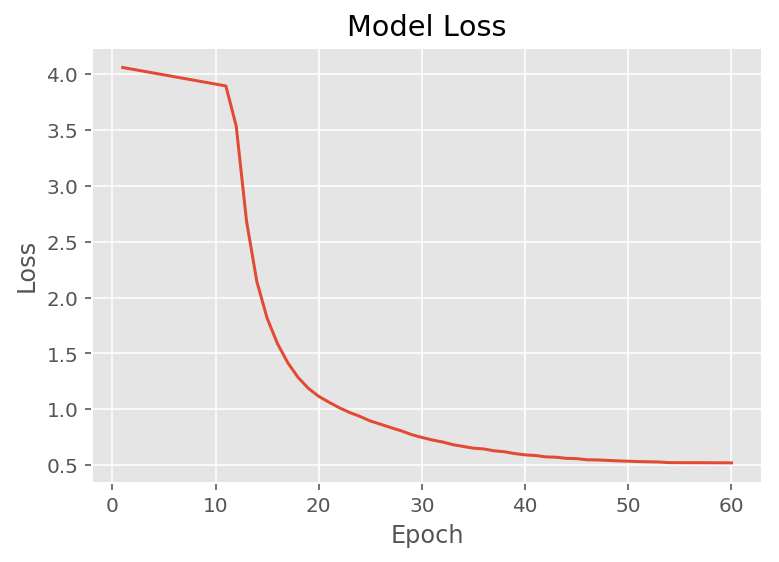

In [31]:
# the model histrory was not saved, so we'll extract the loss from the checkpoints file names

filenames = glob.glob("./weights-improvement*.hdf5")

loss_per_epoch = {}
for file in filenames:
    loss_per_epoch[int(file[22:24])] = float(file[25:31])

loss_per_epoch = sorted(Counter(loss_per_epoch).items(), key=operator.itemgetter(1))
loss_per_epoch.reverse()

x, y = zip(*loss_per_epoch)

plt.plot(x, y)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.show()

The network was trained for 100 epochs which took about 35 hours. We can see in the plot that after 60 epochs the network converged (the rest of the epochs did not show improvement).

### Test the Model - Generate Music
We will now test the network by generating a new music piece based on the Beatles music that the network was trained with. We will use the `generate_notes` function which takes the original notes list, randomly starts with a subset of notes out of that list and uses that to generate a new set of notes which are the prediction generated by the model. It is important to note that while the network receives a list of notes from the original music as input, this list is not getting into the output (which remains 100% pure machine-created music).

In [45]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """

    sequence_length = 100
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(notes)-sequence_length-1)
    pattern = [note_to_int[char] for char in notes[start:start+sequence_length]]
    
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output



# # load the notes used to train the model
with open('data/notes_beatles', 'rb') as filepath:
    notes = pickle.load(filepath)

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

normalized_input, _ = prepare_sequences_for_LSTM(notes, n_vocab)

model = create_network_LSTM(normalized_input, n_vocab)
model.load_weights("weights-improvement-60-0.5211-bigger.hdf5")

prediction_output = generate_notes(model, notes, pitchnames, n_vocab)
create_midi(prediction_output, filename="LSTM_track_beatles")

In [47]:
prediction_output = generate_notes(model, notes, pitchnames, n_vocab)
create_midi(prediction_output, filename="LSTM_track_beatles")

The generated music piece:


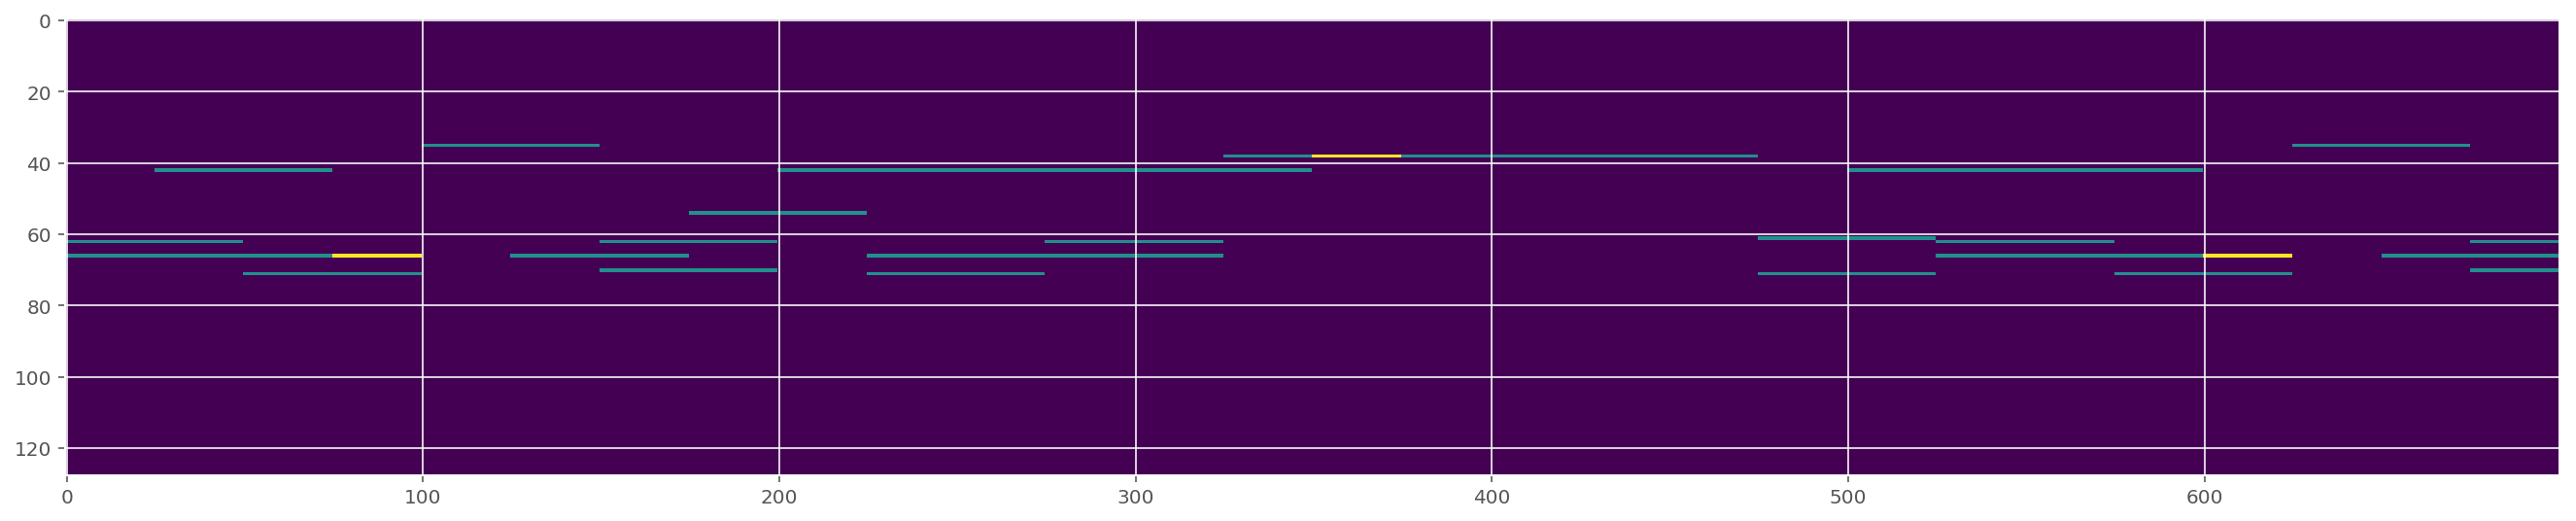

In [48]:
print("The generated music piece:")

pm = pretty_midi.PrettyMIDI("LSTM_track_beatles.mid")
plt.figure(figsize=(23,5))
plt.imshow(pm.get_piano_roll()[:,:700])
plt.show()

We can hear the output of the network by downloading the file from __[this link](https://drive.google.com/open?id=1ZcnLAtmB1K9CdMlLB6IWZwuJcKvioVyD)__, and see the visual representation of the notes above. 

The result is remarkable - the network generated music that sounds close to an actual piece! While this output could be distinguished from a human playing a piano, it definitely has features of a musical piece with a background pattern which resembles a rhythm and an interesting melody. It is important to note that in some parts, there is a repetition that is too long compared to what we would expect from a human-generated music piece. Unlike this output of the network, several other outputs that were generated were much more repetitive, in some cases for their entire length.

## Conclusions
In this project, I worked with two different neural network architectures to test what are the best way to apply deep learning on music data. In both cases, I used a dataset of MIDI music files of music by The Beatles. We first saw that the AE I used was not able to reproduce the music it was presented with to a high level. The LSTM RNN, on the other hand, showed that it was capable of generating new music pieces that sounded somewhat close to human-made music. 

What seems to be the main reason for the described difference in performances is the sequential nature of music. RNNs are designed so that they will be able to capture the sequential nature of the data that they are presented with through the establishment of a memory. The AE, which could only identify general patterns in the music sequence, was not able to perform as good. I cannot conclude that AEs in general are not appropriate for music, as we can __[find examples](https://blog.goodaudience.com/using-tensorflow-autoencoders-with-music-f871a76122ba)__ where they were able to reach a high level of reconstruction with highly detailed music (WAV files). However, it seems like the AE needs to be trained for longer with a much larger dataset (the example before used over 2GB of music), which was far from the case of the AE I used. RNNs, on the other hand, seem to be much more commonly used with music data across many different examples.

Either way, in this project I was able to show that deep learning models are capable of generating new music. With more appropriate models and more data to train on, it is very likely that in the not-so-long-future we will have machines make music that we would not be able to distinguish from the human-made music we hear now.



## Code and files
This notebook, as well as the notes and weights files can be accessed in the Github repository: https://github.com/orsegal/Senior-Year---Projects/tree/master/deep_learning_final

## Resources

Deep Learning and music:
* Huang & Wu - Deep Learning for Music - https://cs224d.stanford.edu/reports/allenh.pdf

Tutorials this work was based on:
* https://github.com/wezleysherman/TFMusicAudioEncoder/blob/master/encoder.py
* https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5 
    * This is also the source of the smaller dataset
* https://blog.keras.io/building-autoencoders-in-keras.html

How to work with midi:
* https://nbviewer.jupyter.org/github/craffel/midi-dataset/blob/master/Tutorial.ipynb

Download the large dataset:
* https://colinraffel.com/projects/lmd/

Recurrent Neural Networks
* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
* https://adventuresinmachinelearning.com/keras-lstm-tutorial/